# Strategies for Optimizing Your Python Code

Acknowledgements: heavily adopted from Jake VanderPlas's 2018 PyCon talk:

- original notebook: <https://gist.github.com/jakevdp/256c3ad937af9ec7d4c65a29e5b6d454>
- Talk: <https://www.youtube.com/watch?v=zQeYx87mfyw>

## K Means: The Algorithm

- Guess some cluster centers
- Repeat until converged
  - assign points to the nearest cluster center
  - set the cluster centers to the mean of assigned points

## {.smaller}

In [1]:
from sklearn.datasets import make_blobs

points, labels_true = make_blobs(
    n_samples=5000, centers=4,
    random_state=0, cluster_std=0.60
    )

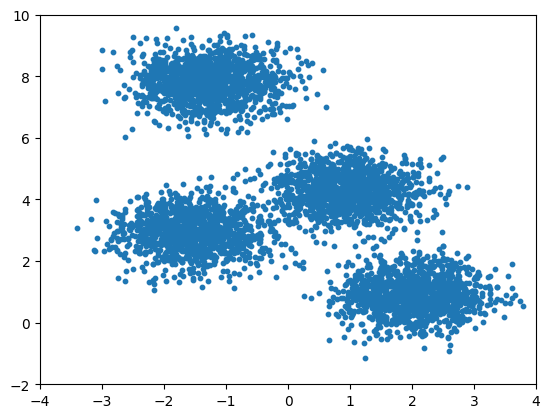

In [61]:
#| classes: fragment
#| output-location: fragment
import matplotlib.pyplot as plt

plt.scatter(points[:, 0], points[:, 1], s=10)
plt.xlim(-4, 4)
plt.ylim(-2, 10)
plt.show()

## Basic Python implementation {.smaller}

In [72]:
def dist(x, y):
    return sum((xi - yi)**2 for xi, yi in zip(x, y))

def find_labels(points, centers):
    labels = []
    for point in points:
        distances = [dist(point, center) for center in centers]
        labels.append(distances.index(min(distances)))
    return labels

def compute_centers(points, labels):
    n_centers = len(set(labels))
    n_dims = len(points[0])
    centers = [[0 for i in range(n_dims)] for j in range(n_centers)]
    counts = [0 for j in range(n_centers)]
    for label, point in zip(labels, points):
        counts[label] += 1
        centers[label] = [a + b for a, b in zip(centers[label], point)]
    return [[x / count for x in center] for center, count in zip(centers, counts)]

def kmeans(points, n_clusters):
    centers = points[-n_clusters:].tolist()
    while True:
        old_centers = centers
        labels = find_labels(points, centers)
        centers = compute_centers(points, labels)
        if centers == old_centers:
            break
    return labels

---

In [59]:
#| output-location: fragment
kmeans(points, 10)[:10]

[5, 3, 4, 5, 0, 4, 9, 6, 0, 7]

In [60]:
#| classes: fragment
#| output-location: fragment
%timeit kmeans(points, 10)

2.76 s ± 31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Strategy #1: line profiling

Put most of your efforts on the parts of the code that actually take the most time. To find those, you can use a line profiling tool (make sure to `pip install line_profiler`).

In [64]:
#| classes: fragment
#| output: false
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


## {.smaller}

In [65]:
#| output-location: fragment
%lprun -f kmeans kmeans(points, 10)

Timer unit: 1e-09 s

Total time: 4.56715 s
File: /var/folders/ng/d9rd9fb92c7bxz9fy7vwpj7m0000gp/T/ipykernel_13369/3233416767.py
Function: kmeans at line 21

Line #      Hits         Time  Per Hit   % Time  Line Contents
    21                                           def kmeans(points, n_clusters):
    22         1     129000.0 129000.0      0.0      centers = points[-n_clusters:].tolist()
    23        54       9000.0    166.7      0.0      while True:
    24        54      45000.0    833.3      0.0          old_centers = centers
    25        54 4389825000.0    8e+07     96.1          labels = find_labels(points, centers)
    26        54  177088000.0    3e+06      3.9          centers = compute_centers(points, labels)
    27        54      57000.0   1055.6      0.0          if centers == old_centers:
    28         1          0.0      0.0      0.0              break
    29         1       1000.0   1000.0      0.0      return labels

## {.smaller}

In [67]:
#| output-location: fragment
%lprun -f find_labels kmeans(points, 10)

Timer unit: 1e-09 s

Total time: 4.57433 s
File: /var/folders/ng/d9rd9fb92c7bxz9fy7vwpj7m0000gp/T/ipykernel_13369/3233416767.py
Function: find_labels at line 4

Line #      Hits         Time  Per Hit   % Time  Line Contents
     4                                           def find_labels(points, centers):
     5        54      72000.0   1333.3      0.0      labels = []
     6    270054   52908000.0    195.9      1.2      for point in points:
     7   2970000 4415870000.0   1486.8     96.5          distances = [dist(point, center) for center in centers]
     8    270000  105452000.0    390.6      2.3          labels.append(distances.index(min(distances)))
     9        54      24000.0    444.4      0.0      return labels

The majority of the compute time (~97% of the `find_labels` function, which itself takes up ~96% of the total `kmeans` function) is spent in calculating the distances, which is an operation repeated over the arrays of point locations.

For repeated operations on arrays, Numpy is your first place to turn.

# 2. NumPy Vectorization / Broadcasting

Optimizes repeated operations on arrays.

## {.smaller}

In [69]:
import numpy as np

def find_labels(points, centers):
    diff = (points[:, None, :] - centers)
    distances = (diff**2).sum(-1)
    return distances.argmin(1)

def compute_centers(points, labels):
    n_centers = len(set(labels))
    n_dims = len(points[0])
    
    centers = [[0 for i in range(n_dims)] for j in range(n_centers)]
    counts = [0 for j in range(n_centers)]
    
    for label, point in zip(labels, points):
        counts[label] += 1
        centers[label] = [a + b for a, b in zip(centers[label], point)]
        
    return [[x / count for x in center] for center, count in zip(centers, counts)]

def compute_centers(points, labels):
    n_centers = len(set(labels))
    return np.array([points[labels == i].mean(0) for i in range(n_centers)])

def kmeans(points, n_clusters):
    centers = points[-n_clusters:]
    while True:
        old_centers = centers
        labels = find_labels(points, centers)
        centers = compute_centers(points, labels)
        if np.all(centers == old_centers):
            break
    return labels

--- 

In [24]:
kmeans(points, 10)[:10]

array([5, 3, 4, 5, 0, 4, 9, 6, 0, 7])

In [25]:
#| classes: fragment
#| output-location: fragment
%timeit kmeans(points, 10)

76 ms ± 169 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


::: fragment
Using NumPy takes the algorithm down from nearly three seconds to below one hundred milliseconds!
:::

::: fragment
The key here is that repeated operations have been pushed into a **compiled layer**. Use NumPy everywhere when doing numerical calculations with arrays.
:::


## Use NumPy everywhere!

::: fragment
Advantages:
:::

- Python overhead per array rather than per array element
- Compact domain specific language for array operations
- NumPy is widely available

::: fragment
Disadvantages:
::: 

- Batch operations can lead to excessive memory usage
- Different way of thinking about writing code

## {.smaller}

In [70]:
#| output-location: fragment
%lprun -f kmeans kmeans(points, 10)

Timer unit: 1e-09 s

Total time: 0.142411 s
File: /var/folders/ng/d9rd9fb92c7bxz9fy7vwpj7m0000gp/T/ipykernel_13369/2497051821.py
Function: kmeans at line 25

Line #      Hits         Time  Per Hit   % Time  Line Contents
    25                                           def kmeans(points, n_clusters):
    26         1      98000.0  98000.0      0.1      centers = points[-n_clusters:]
    27        54      15000.0    277.8      0.0      while True:
    28        54      11000.0    203.7      0.0          old_centers = centers
    29        54   97292000.0    2e+06     68.3          labels = find_labels(points, centers)
    30        54   43640000.0 808148.1     30.6          centers = compute_centers(points, labels)
    31        54    1355000.0  25092.6      1.0          if np.all(centers == old_centers):
    32         1          0.0      0.0      0.0              break
    33         1          0.0      0.0      0.0      return labels

In [73]:
#| classes: fragment
#| output-location: fragment
%lprun -f find_labels kmeans(points, 10)

Timer unit: 1e-09 s

Total time: 4.60709 s
File: /var/folders/ng/d9rd9fb92c7bxz9fy7vwpj7m0000gp/T/ipykernel_13369/3233416767.py
Function: find_labels at line 4

Line #      Hits         Time  Per Hit   % Time  Line Contents
     4                                           def find_labels(points, centers):
     5        54      52000.0    963.0      0.0      labels = []
     6    270054   52181000.0    193.2      1.1      for point in points:
     7   2970000 4453916000.0   1499.6     96.7          distances = [dist(point, center) for center in centers]
     8    270000  100907000.0    373.7      2.2          labels.append(distances.index(min(distances)))
     9        54      33000.0    611.1      0.0      return labels

## {.smaller}

In [74]:
#| output-location: fragment
%lprun -f compute_centers kmeans(points, 10)

Timer unit: 1e-09 s

Total time: 0.276425 s
File: /var/folders/ng/d9rd9fb92c7bxz9fy7vwpj7m0000gp/T/ipykernel_13369/3233416767.py
Function: compute_centers at line 11

Line #      Hits         Time  Per Hit   % Time  Line Contents
    11                                           def compute_centers(points, labels):
    12        54    2770000.0  51296.3      1.0      n_centers = len(set(labels))
    13        54     101000.0   1870.4      0.0      n_dims = len(points[0])
    14      1674     420000.0    250.9      0.2      centers = [[0 for i in range(n_dims)] for j in range(n_centers)]
    15       594     100000.0    168.4      0.0      counts = [0 for j in range(n_centers)]
    16    270054   49242000.0    182.3     17.8      for label, point in zip(labels, points):
    17    270000   30445000.0    112.8     11.0          counts[label] += 1
    18    810000  192816000.0    238.0     69.8          centers[label] = [a + b for a, b in zip(centers[label], point)]
    19      1674     531

::: fragment
We can see that the time is now somewhat balanced between calculating the distances between points, and computing the centers of the clusters.
:::

# 3. Special Data Structures

To further speed up this algorithm, we can use special data structures to help further, provided by the `scikit-learn` and `pandas` packages.

First, use the KD Tree structure designed for nearest neighbor searches, provided by `scikit-learn`.

---

NumPy code:
``` {.python .fragment}
import numpy as np

def find_labels(points, centers):
    diff = (points[:, None, :] - centers) ** 2
    distances = diff.sum(-1)
    return distances.argmin(1)
```

::: fragment
KD-Tree code:
:::
``` {.python .fragment}
from scipy.spatial import cKDTree

def find_labels(points, centers):
    distances, labels = cKDTree(centers).query(points, 1)
    return labels
```

---

Then, computing the centers of the clusters is essentially a "group-by" operation: group values by their label, then aggregate those values in the groups. Pandas offers a very efficient group-by operation in its `DataFrame` structure. 

::: fragment
NumPy code:
::: 
``` {.python .fragment}
def compute_centers(points, labels):
    n_centers = len(set(labels))
    return np.array([points[labels == i].mean(0) for i in range(n_centers)])
```

::: fragment
Pandas code:
:::
``` {.python .fragment}
import pandas as pd

def compute_centers(points, labels):
    df = pd.DataFrame(points)
    return df.groupby(labels).mean().values
```

--- 

In [29]:
from scipy.spatial import cKDTree
import pandas as pd

def find_labels(points, centers):
    distances, labels = cKDTree(centers).query(points, 1)
    return labels

def compute_centers(points, labels):
    df = pd.DataFrame(points)
    return df.groupby(labels).mean().values

def kmeans(points, n_clusters):
    centers = points[-n_clusters:]
    while True:
        old_centers = centers
        labels = find_labels(points, centers)
        centers = compute_centers(points, labels)
        if np.all(centers == old_centers):
            break
    return labels

---

In [30]:
#| output-location: fragment
kmeans(points, 10)[:10]

array([5, 3, 4, 5, 0, 4, 9, 6, 0, 7])

In [31]:
#| classes: fragment
#| output-location: fragment
%timeit kmeans(points, 10)

53.6 ms ± 277 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## {.smaller}

In [32]:
#| output-location: fragment
%lprun -f kmeans kmeans(points, 10)

Timer unit: 1e-09 s

Total time: 0.08276 s
File: /var/folders/ng/d9rd9fb92c7bxz9fy7vwpj7m0000gp/T/ipykernel_13369/3764998874.py
Function: kmeans at line 12

Line #      Hits         Time  Per Hit   % Time  Line Contents
    12                                           def kmeans(points, n_clusters):
    13         1       8000.0   8000.0      0.0      centers = points[-n_clusters:]
    14        54       8000.0    148.1      0.0      while True:
    15        54       9000.0    166.7      0.0          old_centers = centers
    16        54   56628000.0    1e+06     68.4          labels = find_labels(points, centers)
    17        54   25563000.0 473388.9     30.9          centers = compute_centers(points, labels)
    18        54     543000.0  10055.6      0.7          if np.all(centers == old_centers):
    19         1          0.0      0.0      0.0              break
    20         1       1000.0   1000.0      0.0      return labels

::: fragment
Runtime reduced down to ~54 ms, compared to:
:::

- 2.7 s in pure Python
- 76 ms with NumPy vectorization

::: fragment
by taking advantage of specialized data structures designed for the exact low-level algorithms we need.
:::

## {.smaller}

Other useful data structures include:

- `scipy.spatial`: for spatial queries like distances, nearest neighbors, etc.
- `pandas`: for SQL-like grouping & aggregation
- `xarray`: for grouping across multiple dimensions
- `scipy.sparse`: sparse matrices for two-dimensional structured data
- `sparse` package: for N-dimensional structured data
- `scipy.sparse.csgraph`: for graph-like problems (e.g., finding shortest paths)

::: fragment
Advantages: these are often the fastest possible way to solve a particular problem.
:::

::: fragment
Disadvantages: require broad & deep understanding of both algorithms and their available implementations.
::: 

# 4. Cython

Combine powers of C with Python. 

::: fragment
We can do this by adding types, then Cython knows how to compile it down to C code.
:::

---

In [76]:
#| output: false
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [78]:
#| classes: fragment
# Python version

def dist(x, y):
    dist = 0
    for i in range(len(x)):
        dist += (x[i] - y[i]) ** 2
    return dist

def find_labels(points, centers):
    labels = []
    for point in points:
        distances = [dist(point, center) for center in centers]
        labels.append(distances.index(min(distances)))
    return labels

In [79]:
#| classes: fragment
#| output-location: fragment
centers = points[:10]
%timeit find_labels(points, centers)

34.4 ms ± 370 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


--- 

In [87]:
%%cython
#| output: false

cimport numpy as np

cdef double dist(double[:] x, double[:] y):
    cdef double dist = 0
    for i in range(len(x)):
        dist += (x[i] - y[i]) ** 2
    return dist

def find_labels(points, centers):
    labels = []
    for point in points:
        distances = [dist(point, center) for center in centers]
        labels.append(distances.index(min(distances)))
    return labels

In [88]:
#| classes: fragment
#| output-location: fragment
centers = points[:10]
%timeit find_labels(points, centers)

20.3 ms ± 241 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## {.smaller}

In [91]:
%%cython

cimport numpy as np
import numpy as np

cdef double dist(double[:] x, double[:] y):
    cdef double dist = 0
    for i in range(len(x)):
        dist += (x[i] - y[i]) ** 2
    return dist

def find_labels(double[:, :] points, double[:, :] centers):
    cdef int n_points = points.shape[0]
    cdef int n_centers = centers.shape[0]
    cdef double[:] labels = np.zeros(n_points)
    cdef double distance, nearest_distance
    cdef int nearest_index
    
    for i in range(n_points):
        nearest_distance = np.inf
        for j in range(n_centers):
            distance = dist(points[i], centers[j])
            if distance < nearest_distance:
                nearest_distance = distance
                nearest_index = j
        labels[i] = nearest_index
    return np.asarray(labels)

In [92]:
#| classes: fragment
#| output-location: fragment
centers = points[:10]
%timeit find_labels(points, centers)

347 μs ± 906 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


--- 

Advantages:

- Python-like code at C-like speeds!

::: fragment
Disadvantages:
:::

- Explicit type annotation can be cumbersome
- Often requires restructuring code
- Code build becomes more complicated

::: fragment
Use for operations that can't easily be expressed in NumPy.
:::

# 5. Numba

[Numba](https://numba.pydata.org) is a just-in-time (JIT) compiler that compiles Python functions to optimized machine code at runtime using the industry-standard LLVM compiler library.

::: fragment
Numba can *infer* the types without being explicitly told what they are.
::: 

::: fragment
We can frequently accelerate Python code *very* easily using Numba, simply by adding the `@numba.jit(nopython=True)` decorator to functions.
:::

--- 

In [97]:
# pure Python version
def dist(x, y):
    dist = 0
    for i in range(len(x)):
        dist += (x[i] - y[i]) ** 2
    return dist


def find_labels(points, centers):
    labels = []
    min_dist = np.inf
    min_label = 0
    for i in range(len(points)):
        for j in range(len(centers)):
            distance = dist(points[i], centers[j])
            if distance < min_dist:
                min_dist, min_label = distance, j
        labels.append(min_label)
    return labels

In [98]:
#| classes: fragment
#| output-location: fragment
centers = points[:10]
%timeit find_labels(points, centers)

34.1 ms ± 240 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


---

In [99]:
import numba

@numba.jit(nopython=True)
def dist(x, y):
    dist = 0
    for i in range(len(x)):
        dist += (x[i] - y[i]) ** 2
    return dist

@numba.jit(nopython=True)
def find_labels(points, centers):
    labels = []
    min_dist = np.inf
    min_label = 0
    for i in range(len(points)):
        for j in range(len(centers)):
            distance = dist(points[i], centers[j])
            if distance < min_dist:
                min_dist, min_label = distance, j
        labels.append(min_label)
    return labels

In [100]:
#| classes: fragment
#| output-location: fragment
centers = points[:10]
%timeit find_labels(points, centers)

106 μs ± 7.21 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


--- 

Advantages:

- Python code JIT-compiled to Fortran speeds!

::: fragment
Disadvantages:
:::

- Heavy dependency chain (LLVM)
- Some Python constructs not supported
- Still a bit finnicky

::: fragment
Recommendation: definitely use for analysis scripts, but be more cautious using in packages as a dependency.
::: 

::: fragment
Also possible to automatically parallelize loops on CPUs and GPUs, but this requires special care.
:::

# 6. Dask

Useful for when your data becomes too large for a single machine's memory, or you want to distribute your work across systems.


--- 

Typical data manipulation with NumPy:


In [2]:
#| classes: fragment
#| output-location: fragment
import numpy as np
a = np.random.randn(1000)
b = a * 4
b_min = b.min()
print(b_min)

-14.778280420773221


--- 

Same operation with Dask:

In [3]:
#| classes: fragment
#| output-location: fragment
import dask.array as da
a2 = da.from_array(a, chunks=200)
b2 = a2 * 4
b2_min = b2.min()
print(b2_min)

dask.array<min-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>


In [4]:
#| classes: fragment
#| output-location: fragment
b2_min.compute()

np.float64(-14.778280420773221)

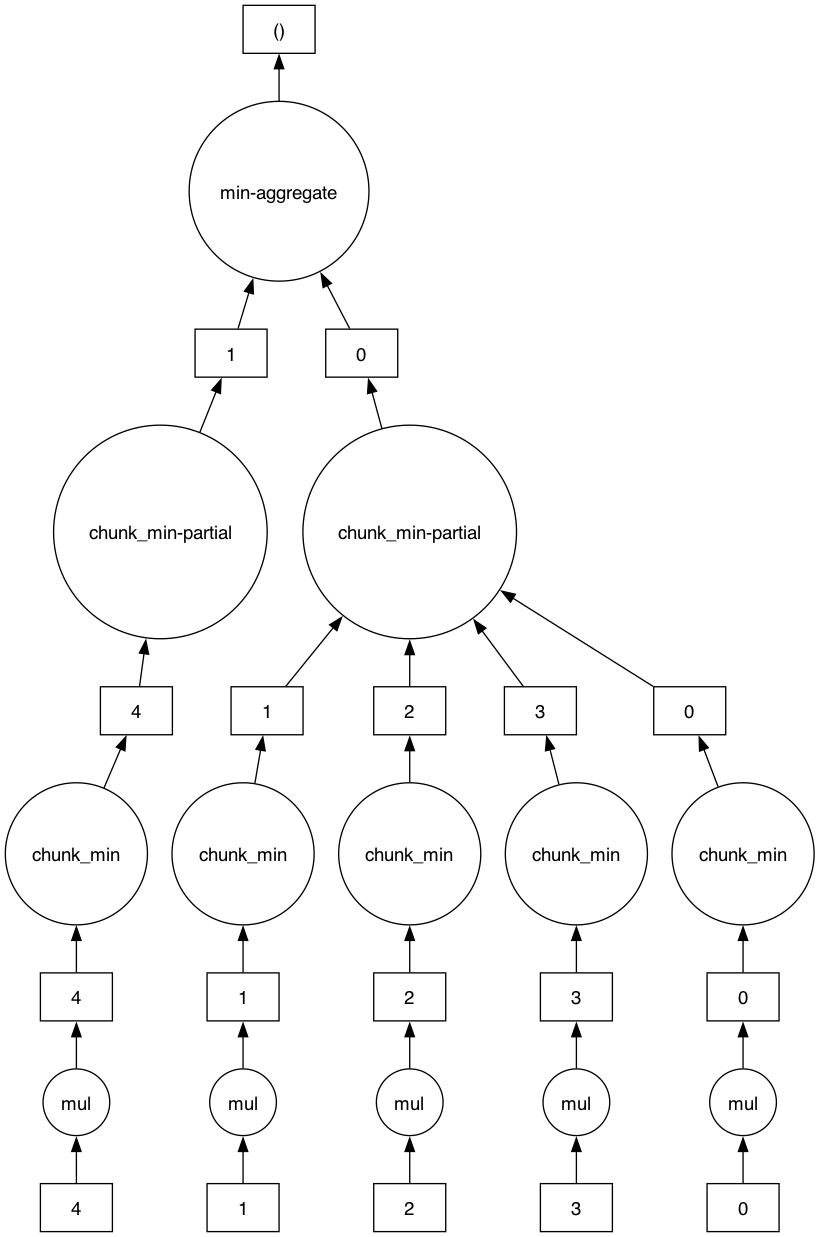

In [5]:
#| classes: fragment
#| output: false
b2_min.visualize(filename="dask_ex.png")

--- 

![](dask_ex.png)

--- 

In [6]:
#| output-location: fragment
from dask import array as da
from dask import dataframe as dd

points_dask = da.from_array(points, chunks=1000)
result = (points_dask ** 2).sum(1)
result.compute()

array([ 5.94673918, 14.00964977, 13.12598814, ..., 64.21143425,
       67.46733724, 51.7011693 ])

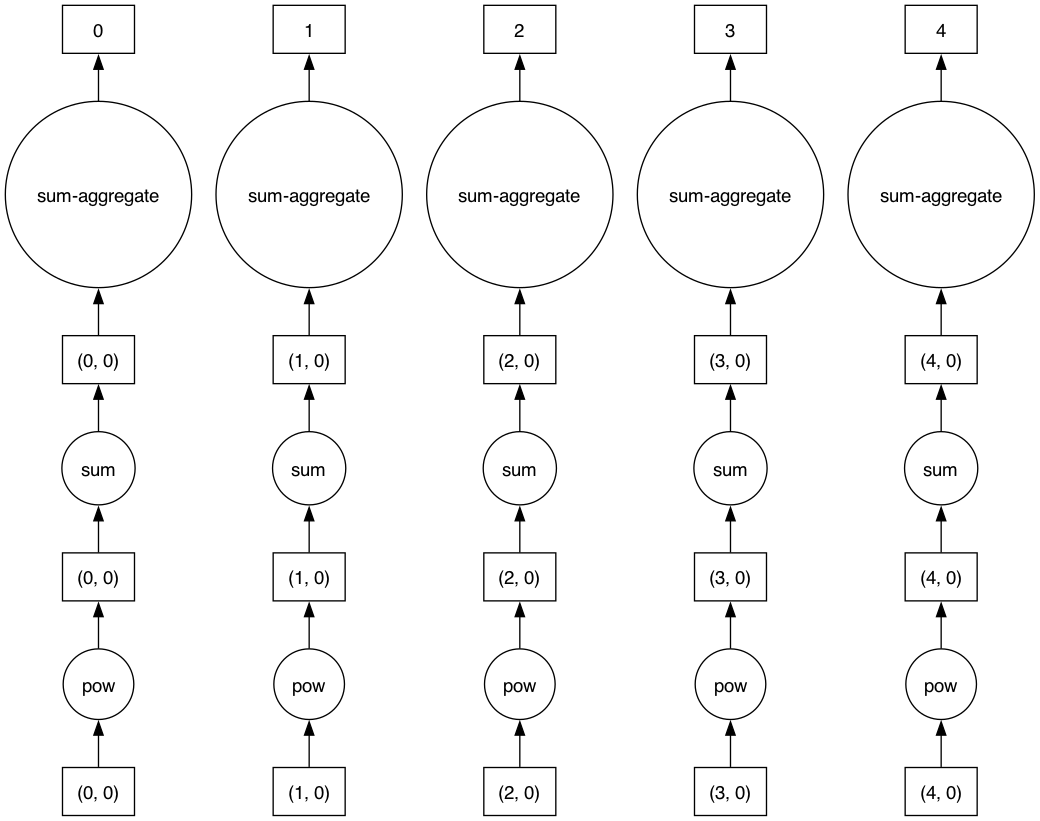

In [7]:
#| output: false
#| classes: fragment
result.visualize(filename='dask_distance.png')

--- 

![](./dask_distance.png)

---

In [8]:
from dask import array as da

def find_labels(points, centers):
    diff = (points[:, None, :] - centers)
    distances = (diff ** 2).sum(-1)
    return distances.argmin(1)

centers = points[:10]

points_dask = da.from_array(points, chunks=1000)
centers_dask = da.from_array(centers, chunks=5)

labels_dask = find_labels(points_dask, centers_dask)

In [9]:
#| classes: fragment
#| output-location: fragment
labels_dask.compute()

array([0, 1, 2, ..., 6, 9, 6])

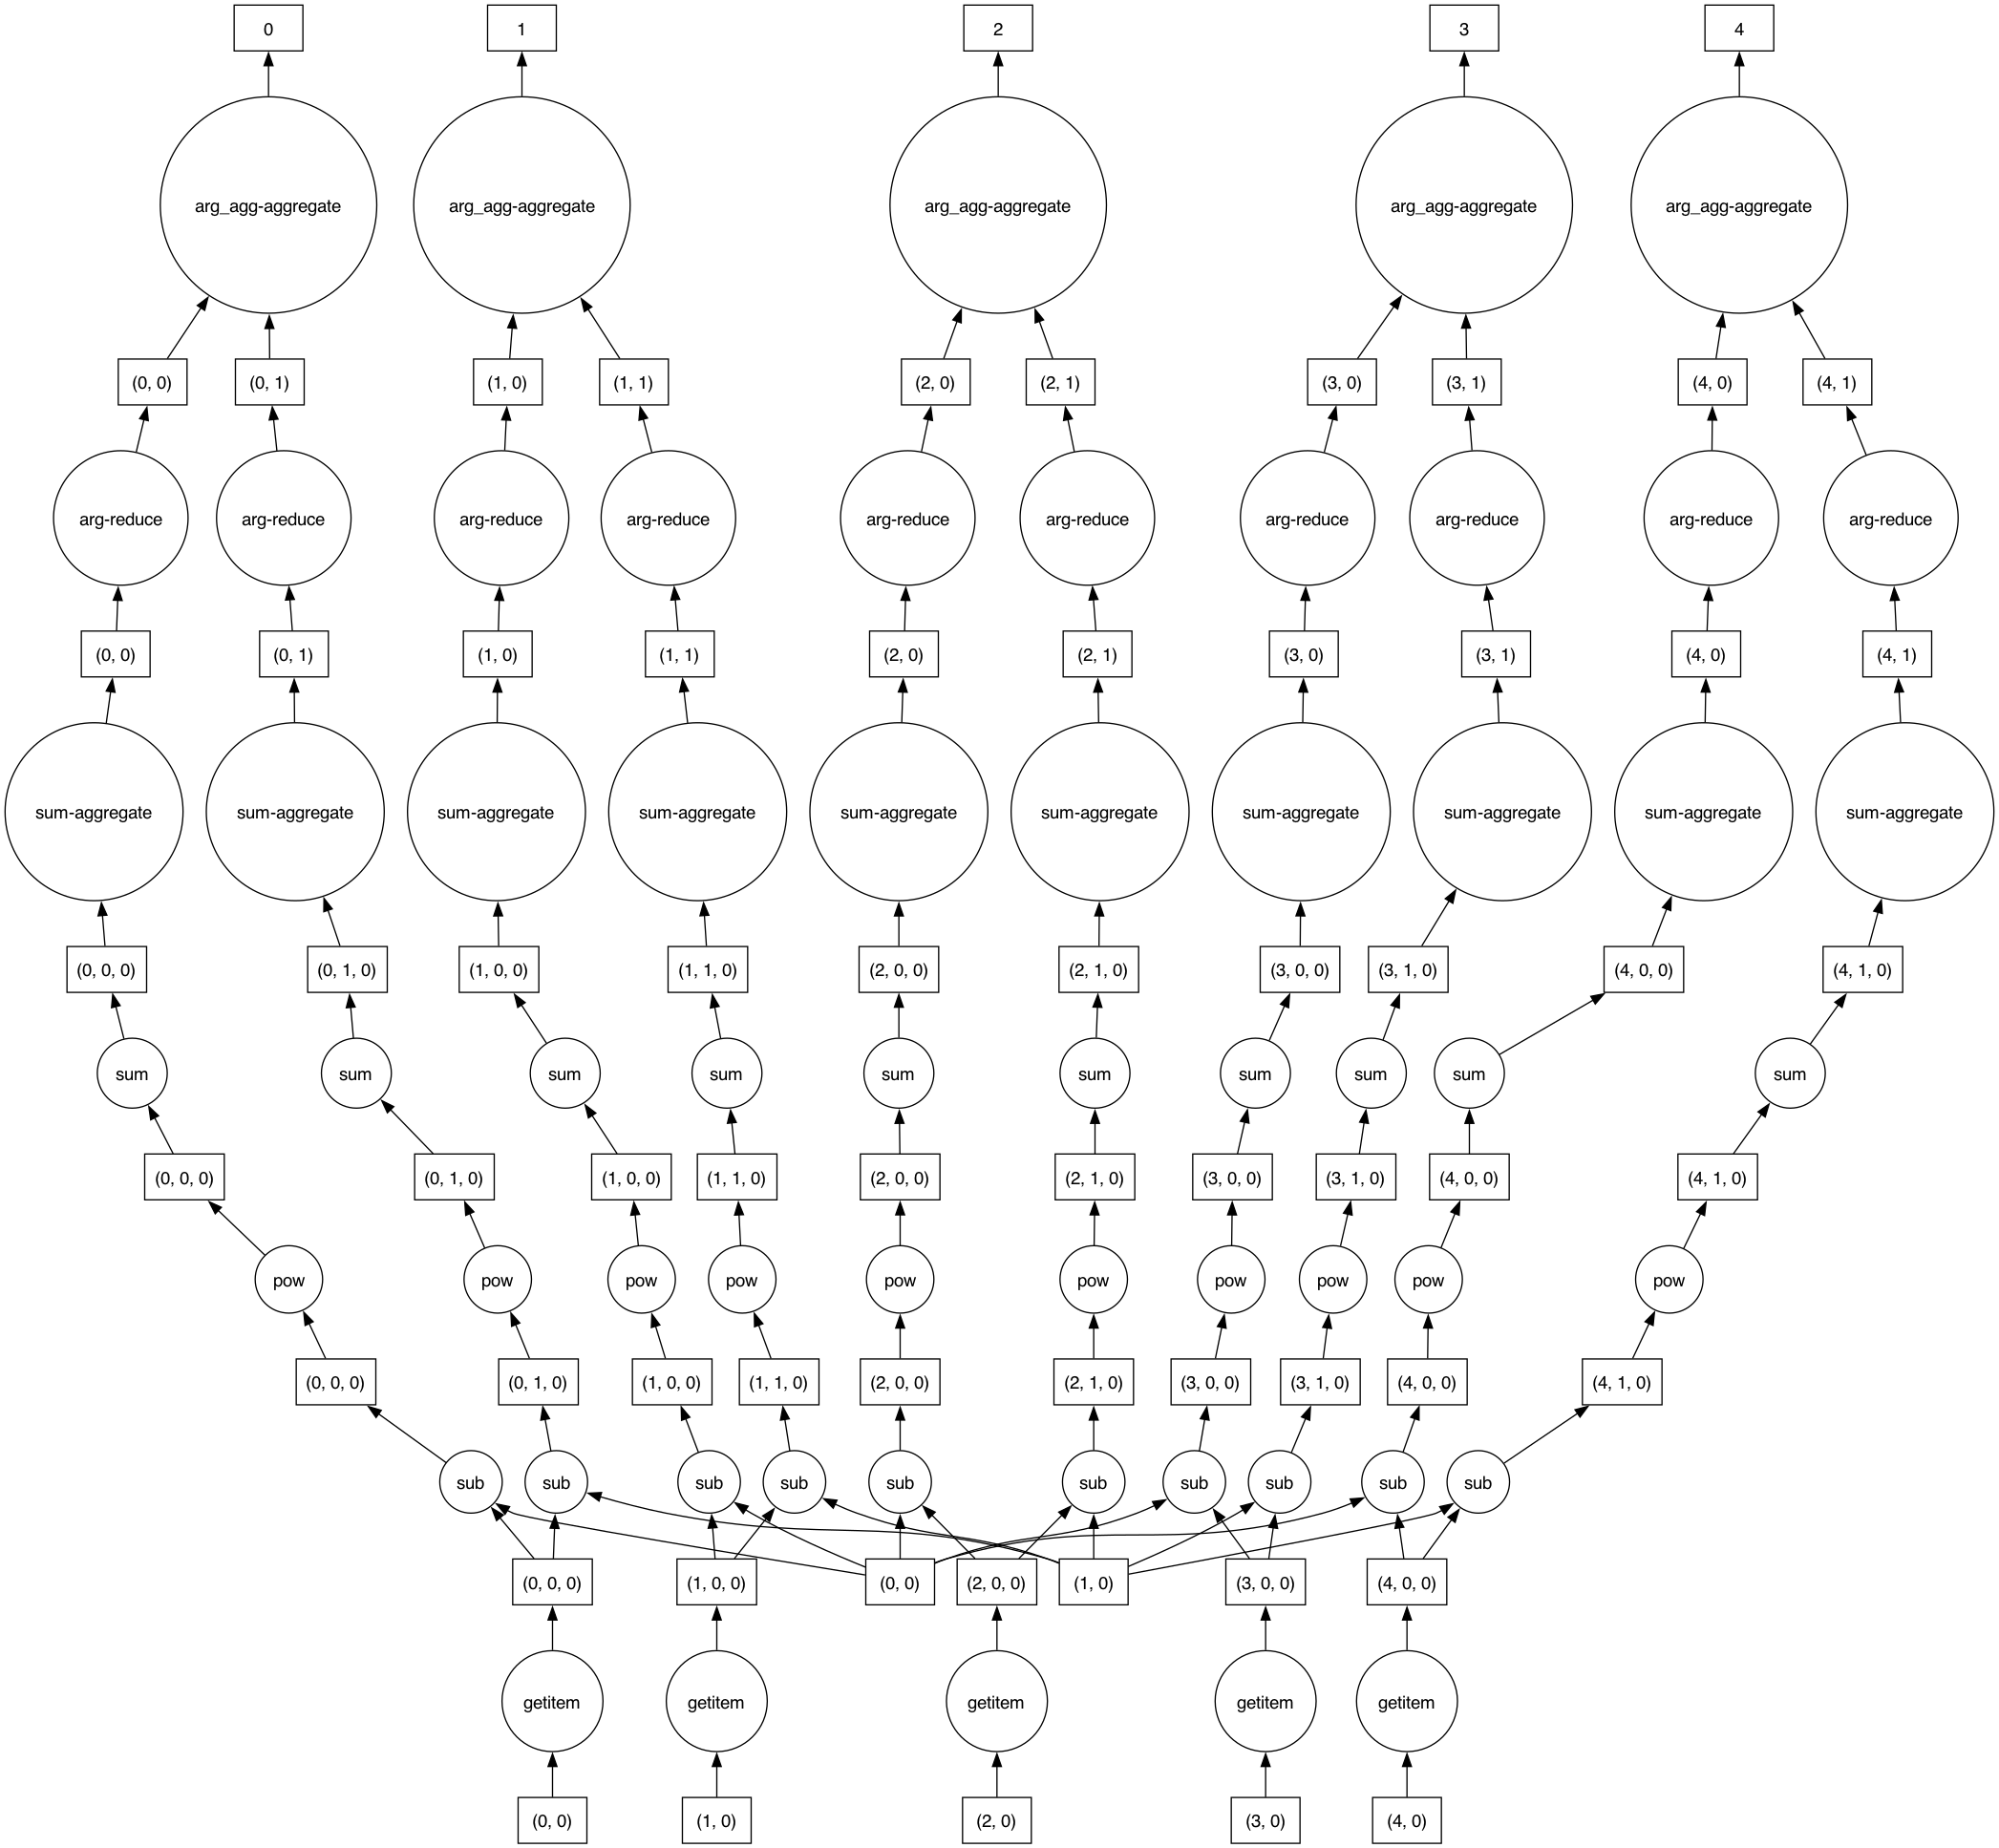

In [14]:
#| classes: fragment
#| output: false
labels_dask.visualize(filename='dask-labels.png')

--- 

![](./dask-labels.png)

--- 

In [19]:
from dask import dataframe as dd

def compute_centers(points, labels):
    points_df = dd.from_dask_array(points, columns=['x', 'y'])
    points_df['label'] = dd.from_dask_array(labels)
    return points_df.groupby('label')['x', 'y'].mean()

result = compute_centers(points_dask, labels_dask)

In [20]:
#| classes: fragment
#| output-location: fragment
result.compute().values

array([[ 2.00922872,  1.03540404],
       [-2.0667431 ,  2.52306223],
       [-0.8672449 ,  3.01911047],
       [ 2.22058825, -0.07949264],
       [ 0.80306779,  4.89056466],
       [-1.70344324,  3.23137327],
       [-1.60575186,  7.32973674],
       [-0.69320682,  7.69520974],
       [ 1.11008872,  3.98520896],
       [-1.41988679,  8.41475127]])

---

In [17]:
def find_labels(points, centers):
    diff = (points[:, None, :] - centers)
    distances = (diff ** 2).sum(-1)
    return distances.argmin(1)

def compute_centers(points, labels):
    points_df = dd.from_dask_array(points, columns=['x', 'y'])
    points_df['label'] = dd.from_dask_array(labels)
    return points_df.groupby('label')['x', 'y'].mean()

def kmeans(points, n_clusters):
    centers = points[-n_clusters:]
    points = da.from_array(points, 1000)
    while True:
        old_centers = centers
        labels = find_labels(points, da.from_array(centers, 5))
        centers = compute_centers(points, labels)
        centers = centers.compute().values
        if np.all(centers == old_centers):
            break
    return labels.compute()

In [18]:
#| classes: fragment
#| output-location: fragment

%timeit kmeans(points, 10)

1.34 s ± 184 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


--- 

Advantages:

- Easy distributed coding, often with no change to NumPy or Pandas code!
- Even works locally on out-of-core data

::: fragment
Disadvantages:
::: 

- High overhead, so not suitable for smaller problems

::: fragment
Recommendation: use when data size or computation time warrants
:::

# 7. Find an existing implementation

::: fragment
For example, `scikit-learn`'s k-means:
:::

In [21]:
#| classes: fragment
#| output-location: fragment
from sklearn.cluster import KMeans

%timeit KMeans(4).fit_predict(points)

2.24 ms ± 98.4 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Takehome messages {.smaller}

1. Start with line profiling to identify expensive parts of code.
2. Rely heavily on NumPy arrays and vectorization/broadcasting of array operations.
3. Use specialized data structures and associated functions when possible.
4. Cython can enable C-like speeds, but makes code more complicated.
5. Numba can rapidly speed up many calculations with JIT compilation.
6. Dask can enable Distributed operations over large data.
7. Don't reinvent the wheel–use existing implementations when possible!